# Analysis of Brawl Stars Data Set

Brawl Stars is a mobile online multiplayer battle game. A player choses a Brawler as game character and plays against other players or AI opponents. Currently there exist 36 different Brawlers, which a player can choose from. Each Brawler has a power level from 1 to 10. With the help of the in-game loot boxes those power levels can be upgraded. 
There are several playable modes, which are updated in regular intervals (every 24hours). Of course, it should also be mentioned that each mode has its preferred characters.
There exist several game modes, where you either play solo or in a team of 2 or 3 against other players/teams or AI opponents.

Every groupmember is an active Brawl Stars gamer. That's the reason why we have decided to analyse some interesting insights of the Brawl Stars dataset. In the video below, you can see a small snipet of the mode "Brawlball". 

In [2]:
from IPython.display import Video
Video("brawlball.mp4")

# Preliminaries

- To process and clean the Brawl Stars Data Set we make use of python libraries which are designed for data processing.
- To collect the Brawl Stars Data Set a Brawl Stars API wrapper called brawlstats is used.

Import the default pyhton libraries for data processing.

In [1]:
import os, json
import random
import pandas as pd # for data stuff
import numpy as np # for importing data i think, not sure anymore
import matplotlib.pyplot as plt #for plotting

# the modules below are used in "Analys Models" section
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from pandas.io.json import json_normalize


Install brawlstats, a python wrapper to retrieve data from the Brawl Stars API
 - https://brawlstats.readthedocs.io/en/latest/index.html

In [2]:
!pip install brawlstats

# Data Collection

- We collect battlelogs from the Brawl Stars API.

Import brawlstats 

In [3]:
import brawlstats
import time

Establish connection to Brawl Stars API. A token resp. API Key is needed. Follow the steps below to obtain a token.
- create an account at: https://developer.brawlstars.com/#/
- get your IPv4 with: https://www.whatismyip.org/
- create an API Key on https://developer.brawlstars.com/#/ for your account and your API Key
- save your API key in this directory in a file named: token_brawlstats.txt
- run the cell below to establish the connection to the API

In [5]:
path = os.getcwd()
token_file =  open(os.path.join(path, "token_brawlstats.txt"), 'r')
token = token_file.read()
token_file.close()

client = brawlstats.Client(token)

- retrieve the top 200 players
- each player object contains a list of battle logs. Those battle logs contain meta data about the player's most recent played games. Those battlelogs form the raw data used for this project
- If we collect data from the API, the most recent battle logs will be retrieved. Therefore, we decided to store the retrieved data in "battlelog.json" such that we can continue with the same data every time this jupyter notebook is used. However, one could delete the current "battlelog.json" file in order to create a new data set from recently played games
- If you run the cell below a new data set is collected if no curent "battlelog.json" exists. However, if a new data set is collected, some adapations in this projects need to be made.

we assume the skill level of the top 200 players in the game is about the same. Therefore all retrieved battle logs are from players with a very high skill level, making the raw data more consistent and not depending on the skill level of a player


In [7]:
if not os.path.isfile("battlelogs.json"):
    
    # retrieve the player objects of the top 200 players
    tags_top_200_players = [player["tag"] for player in client.get_rankings(ranking='players', limit=200)]
    top_200_players = [client.get_player(tag) for tag in tags_top_200_players]
    
    # retrive their battlelogs with the corresponding player tag and stor it in "battlelogs.json" file
    with open("battlelogs.json", "w") as battlelog_file:
        for player in top_200_players:
            player_battlelogs = client.get_battle_logs(player.tag)
            for battlelog in player_battlelogs:
                battlelogs[index] = {}
                battlelogs[index]["player_tag"] = player.tag
                battlelogs[index]["battlelog"] = battlelog
                index += 1
        json.dump(battlelogs, battlelog_file)
        

# Data Cleaning

- some of the top players play against each other. Duplicates can be filtered since a battle log contains a unique key = "battle_time"

In [8]:
# read in the battlelogs.json file
with open("battlelogs.json",'r') as in_file:
    battlelogs = json.load(in_file)
    in_file.close()
    
# initialize list for unique battlelogs
unique_battlelogs = []
used_battle_times = []

# iterate over all battle logs
for key in battlelogs.keys():
    
    # get the battle time of the current battle log which is a unique key
    current_battle_time = battlelogs[key]['battlelog']["battle_time"]
    
    # append the current battle log if 
    # it is not already in the list of unique battle logs
    if not current_battle_time in used_battle_times:
        used_battle_times.append(current_battle_time)
        unique_battlelogs.append(battlelogs[key])

print("The total number of unique battle logs is: {}\n".format(len(unique_battlelogs)))
print("Below is a full battle log: ")    
print(json.dumps(unique_battlelogs[1], sort_keys=True, indent=4))
 
      

The total number of unique battle logs is: 4301

Below is a full battle log: 
{
    "battlelog": {
        "battle": {
            "duration": 143,
            "mode": "gemGrab",
            "result": "defeat",
            "star_player": {
                "brawler": {
                    "id": 16000013,
                    "name": "POCO",
                    "power": 10,
                    "trophies": 894
                },
                "name": "Lil,\u30c7\u30e1\u30eb\u26c4",
                "tag": "#YU2VVGLQ"
            },
            "teams": [
                [
                    {
                        "brawler": {
                            "id": 16000021,
                            "name": "GENE",
                            "power": 9,
                            "trophies": 1231
                        },
                        "name": "VestA\u2698\uc81c\ub85c",
                        "tag": "#8QRPGLQJJ"
                    },
                    {
                 

# Data Processing
- The Brawlers of the top players are analysed to see if they have most of their Brawlers on the max power level.

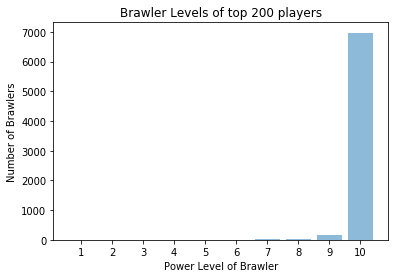

In [9]:
# retrieve the player objects of the top 200 players
tags_top_200_players = [player["tag"] for player in client.get_rankings(ranking='players', limit=200)]
top_200_players = [client.get_player(tag) for tag in tags_top_200_players]


# initialize brawler levels count to 0
# brawlers can be from level 1 to 10
brawler_levels = {}
for i in range(1, 11):
    brawler_levels[i] = 0
    
# loop over the top 200 players
for player in top_200_players:
    
    # loop over the brawlers of the current player
    for brawler in player.brawlers:
        # increment
        brawler_levels[brawler["power"]] += 1

# create a bar plot of the distribution of the brawler power levels
objects = brawler_levels.keys()
y_pos = np.arange(len(objects))
performance = brawler_levels.values()

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.xlabel("Power Level of Brawler")
plt.ylabel('Number of Brawlers')
plt.title('Brawler Levels of top 200 players')

plt.show()

The plot clearly shows that the top 200 players have their brawler mostly on the max power level

# Displaying information about Modes and Maps (Occurence)

 We do want to have the number of games played for the different modes in order to be able to decide which mode to take.
 
 Additionally, we did the same with the different maps, although due to the small number for each map we rather focused on the game mode and decided to further analyse the game mode called "BrawlBall"

In [10]:

### Retrieves information about the modes played and returns a dictionary with key:value (mode: counter)
modedict = {}
current_mode = ''
for log in unique_battlelogs:
    current_mode = log["battlelog"]["event"]["mode"]
    if current_mode not in modedict.keys():
        modedict[current_mode] = 0
    modedict[current_mode] = modedict[current_mode] + 1
    

### Get the mode with highest games completed in our data
max_key = max(modedict, key=modedict.get)  
print(max_key)
print(modedict)
summode = 0
for val in modedict.values():
    summode = summode + val
print(summode)
    

### Retrieves counter information about the different maps played and returns a dictionary with key:value (map: counter) pairs
mapdict = {}
current_map = ''
for log in unique_battlelogs:
    current_map = log["battlelog"]["event"]["map"]
    if current_map not in mapdict.keys():
        mapdict[current_map] = 0
    mapdict[current_map] = mapdict[current_map] + 1
    
print(mapdict)
summap = 0
for values in mapdict.values():
    summap = summap + values
print(summap)
            

brawlBall
{'gemGrab': 511, 'brawlBall': 1158, 'siege': 140, 'heist': 795, 'soloShowdown': 380, 'bounty': 66, 'hotZone': 330, 'duoShowdown': 506, 'roboRumble': 415}
4301
{'Crystal Arcade': 9, 'Spare Space': 225, 'Backyard Bowl': 914, 'Deathcap Trap': 213, 'Nuts & Bolts': 97, 'Hot Potato': 770, 'Stocky Stockades': 762, 'Factory Rush': 11, 'Minecart Madness': 11, 'Layer Cake': 18, 'Pit Stop': 14, 'Triple Dribble': 22, 'Quarter Pounder': 289, 'Warped Arena': 25, 'Junk Park': 9, 'Field Goal': 11, 'Deep Diner': 6, 'Deeper Danger': 27, 'Tornado Ring': 3, 'Penalty Kick': 4, 'Hard Rock Mine': 16, 'Keep Safe': 415, 'Street Brawler 2': 39, 'Dark Passage': 5, 'Well Cut': 7, 'Shoulder Bash': 1, 'Galaxy Arena': 4, 'Rocky Blocks': 82, 'Super Stadium': 18, 'Double Swoosh': 8, 'Feast or Famine': 2, 'Thousand Lakes': 25, 'Post Haste': 119, 'Undermine': 2, 'Escape Velocity': 2, 'Cell Division': 7, 'Chill Space': 4, 'Some Assembly Required': 20, 'Canal Grande': 12, 'Pinhole Punt': 9, 'Pinball Dreams': 6, 

## Creating a Dataframe for further analysis
Since we will be able to perform certain actions on the dataset and want to get rid of the tedious JSON format, we're pulling out the important data for future analysis from the JSON and add it to a Dataframe. Additionally, the Game result (victory, draw, loss) is now numerically encoded.
As a last step, we removed games where a brawler was present at least twice in the same team. As this normally does not occur on games, we wanted to remove data that showed this property.

In [11]:
### Narrowing down the data to have only variables of interest

brawl_dicts = []
for log in unique_battlelogs:
    if log["battlelog"]["event"]["mode"] == max_key:
        brawl_dicts.append(log)
        
print(len(brawl_dicts))
###print(brawl_dicts)

##removing any unnecessary information from the source

df = pd.DataFrame(columns=['WinningTeam','BattleTime','playerTag','mode','map','result','StarPlayerTag','StarPlayerBrawler','Brawler1Name','Brawler1Tag','Brawler2Name','Brawler2Tag','Brawler3Name','Brawler3Tag','Brawler4Name',
                           'Brawler4Tag','Brawler5Name','Brawler5Tag','Brawler6Name','Brawler6Tag'])

    
for i in range(len(brawl_dicts)):
    log = brawl_dicts[i]
    row = []
    
    if log["battlelog"]["battle"]["result"] == "draw":
        row.append(0)
    elif (log["player_tag"] == log["battlelog"]["battle"]["teams"][0][0]["tag"] or log["player_tag"] == log["battlelog"]["battle"]["teams"][0][1]["tag"] or log["player_tag"] == log["battlelog"]["battle"]["teams"][0][2]["tag"]) and log["battlelog"]["battle"]["result"] == "victory":
        row.append(1)
    else:
        row.append(2)
    row.append(log["battlelog"]["battle_time"])
    row.append(log["player_tag"])
    row.append(log["battlelog"]["event"]["mode"])
    row.append(log["battlelog"]["event"]["map"])
    row.append(log["battlelog"]["battle"]["result"])
    row.append(log["battlelog"]["battle"]["star_player"]["tag"])
    row.append(log["battlelog"]["battle"]["star_player"]["brawler"]["name"])
    row.append(log["battlelog"]["battle"]["teams"][0][0]["brawler"]["name"])
    row.append(log["battlelog"]["battle"]["teams"][0][0]["tag"])
    row.append(log["battlelog"]["battle"]["teams"][0][1]["brawler"]["name"])
    row.append(log["battlelog"]["battle"]["teams"][0][1]["tag"])
    row.append(log["battlelog"]["battle"]["teams"][0][2]["brawler"]["name"])
    row.append(log["battlelog"]["battle"]["teams"][0][2]["tag"])
    row.append(log["battlelog"]["battle"]["teams"][1][0]["brawler"]["name"])
    row.append(log["battlelog"]["battle"]["teams"][1][0]["tag"])
    row.append(log["battlelog"]["battle"]["teams"][1][1]["brawler"]["name"])
    row.append(log["battlelog"]["battle"]["teams"][1][1]["tag"])
    row.append(log["battlelog"]["battle"]["teams"][1][2]["brawler"]["name"])
    row.append(log["battlelog"]["battle"]["teams"][1][2]["tag"])
    df.loc[i] = row

df = df.replace(to_replace = 'victory', value= 1)
df = df.replace(to_replace = 'defeat', value= -1)
df = df.replace(to_replace = 'draw', value= 0)


df.head(10)


### Dropping data where a brawler is present twice in the same team, as this is normally not permitted in games
duplicateBrawlersIndices = []
for index, row in df.iterrows():
    if (row["Brawler1Name"] == row["Brawler2Name"] or row["Brawler1Name"] == row["Brawler2Name"] or row["Brawler2Name"] == row["Brawler3Name"]
        or row["Brawler4Name"] == row["Brawler5Name"] or row["Brawler4Name"] == row["Brawler6Name"] or row["Brawler5Name"] == row["Brawler6Name"]):
        duplicateBrawlersIndices.append(index)
df = df.drop(duplicateBrawlersIndices)



df.to_csv("rawdata.csv",index=False)


1158


### Preparing Data to check brawler-specific Pickrate, meaning the chance (in %) of each brawler getting picked for BrawlBall mode

In [19]:
## List of all Brawlernames to simplify certain actions

brawlerlist = ['SHELLY','NITA','COLT','BULL','JESSIE','BROCK','DYNAMIKE','BO','TICK','8-BIT','EMZ','EL PRIMO','BARLEY','POCO','ROSA','DARRYL','PENNY','CARL','JACKY','PIPER','PAM','FRANK','BIBI','BEA','RICO','MORTIS','TARA','GENE','MAX','MR. P','SPROUT','SPIKE','CROW','LEON','SANDY','GALE']
print(len(brawlerlist))

## Creating a new Dataframe for Calucalating the Pickrate of each brawler (through duplicate removal and comparing to teams (not games), may not exceed 100%)
newdf = pd.DataFrame(brawlerlist,columns=['Name'])

OccurencesBrawler =[]
TotalGames = []

for brawler in brawlerlist:
    x = list(df.Brawler1Name).count(brawler)
    y = list(df.Brawler2Name).count(brawler)
    z = list(df.Brawler3Name).count(brawler)
    a = list(df.Brawler4Name).count(brawler)
    b = list(df.Brawler5Name).count(brawler)
    c = list(df.Brawler6Name).count(brawler)
    
    total_sum = a + b + c + x + y + z
    OccurencesBrawler.append(total_sum)
    ### As each team may choose every brawler (although premade teams are not allowed to pick duplicates), we derive the TotalTeam Number from the Total games played.
    TotalGames.append(len(df.index)*2)

    
## Adding New columns for calulcation of the "pick rate" (how often is the respective brawler picked)
## Additionally, to perform row-wise transformations, the Number of Total games is written in each row
newdf['Occurence'] = OccurencesBrawler
newdf['TotalGames'] = TotalGames

newdf['PickRate %'] = newdf.Occurence / newdf.TotalGames * 100
newdf.sort_values(by='PickRate %',ascending = False)

36


,Name,Occurence,TotalGames,PickRate %
23,BEA,749,2292,32.678883
5,BROCK,521,2292,22.731239
25,MORTIS,469,2292,20.462478
20,PAM,438,2292,19.109948
10,EMZ,355,2292,15.488656
32,CROW,285,2292,12.434555
19,PIPER,285,2292,12.434555
27,GENE,283,2292,12.347295
2,COLT,260,2292,11.343805
22,BIBI,223,2292,9.729494


### Preparation and Constructing Tables that show brawler-specific Winrate (in %), show how many times the brawler (individually) wins

In [20]:
## List of all Brawlernames to simplify certain actions

brawlerlist = ['SHELLY','NITA','COLT','BULL','JESSIE','BROCK','DYNAMIKE','BO','TICK','8-BIT','EMZ','EL PRIMO','BARLEY','POCO','ROSA','DARRYL','PENNY','CARL','JACKY','PIPER','PAM','FRANK','BIBI','BEA','RICO','MORTIS','TARA','GENE','MAX','MR. P','SPROUT','SPIKE','CROW','LEON','SANDY','GALE']


## Creating a new Dataframe for Calucalating the Pickrate of each brawler, keep in mind that every non-premade team may have duplicate champions, therefore the Pickrate could theoretically exceed 100% (up to 300%)
windf = pd.DataFrame(brawlerlist,columns=['Name'])

## List that will be filled with the number each brawler has played in the dataset.
GamesPlayed =[]

for brawler in brawlerlist:
    x = list(df.Brawler1Name).count(brawler)
    y = list(df.Brawler2Name).count(brawler)
    z = list(df.Brawler3Name).count(brawler)
    a = list(df.Brawler4Name).count(brawler)
    b = list(df.Brawler5Name).count(brawler)
    c = list(df.Brawler6Name).count(brawler)
    
    total_sum = a + b + c + x + y + z
    GamesPlayed.append(total_sum)
    
winningOccurences = []
#%%
for brawler in brawlerlist:
    brawlwincount = 0
    for index, row in df.iterrows():
        if row["WinningTeam"] == 1 and (row["Brawler1Name"] == brawler or row["Brawler2Name"] == brawler or row["Brawler3Name"] == brawler):
            brawlwincount += 1
        elif row["WinningTeam"] == 2 and (row["Brawler4Name"] == brawler or row["Brawler5Name"] == brawler or row["Brawler6Name"] == brawler):
            brawlwincount += 1
    winningOccurences.append(brawlwincount)

## Appended Games played to the dataframe to make calculations
windf['Games Played'] = GamesPlayed
windf['Games Won'] = winningOccurences
windf['Winrate %'] = windf['Games Won'] / windf['Games Played'] * 100
windf.sort_values(by='Winrate %', ascending=False)

##Side note: It may occur that the teams playing against each other have the same brawler in one game, this would result in a winrate of 50% (if only games where both teams the same brawler were counted).

,Name,Games Played,Games Won,Winrate %
35,GALE,191,138,72.251309
29,MR. P,143,99,69.230769
16,PENNY,220,152,69.090909
9,8-BIT,54,35,64.814815
19,PIPER,285,173,60.701754
17,CARL,90,52,57.777778
5,BROCK,521,301,57.773512
28,MAX,195,111,56.923077
20,PAM,438,242,55.251142
24,RICO,96,53,55.208333


# Preparation for Model Building

- do some stratification perhaps

In [21]:
print("some very nice plots like the ones above")

some very nice plots like the ones above


# Discussion or whatever
# Model1

- write down our insights or maybe do some further coding in the cell below

In [22]:
print("finally, done with this")

finally, done with this


In [23]:
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.preprocessing import TransactionEncoder

In [24]:
df = pd.read_csv("rawdata.csv")
print(df.shape)

(1146, 20)


In [25]:
df.head(5)

,WinningTeam,BattleTime,playerTag,mode,map,result,StarPlayerTag,StarPlayerBrawler,Brawler1Name,Brawler1Tag,Brawler2Name,Brawler2Tag,Brawler3Name,Brawler3Tag,Brawler4Name,Brawler4Tag,Brawler5Name,Brawler5Tag,Brawler6Name,Brawler6Tag
0,1,20200530T122433.000Z,#9U2QJ0P,brawlBall,Backyard Bowl,1,#9U2QJ0P,BEA,PIPER,#VGR0CJ29,BEA,#9U2QJ0P,GENE,#9UR09Q80Y,BEA,#222VJU0CU,BROCK,#20C2RRRGY,EMZ,#Y220JJJ9
1,1,20200530T121808.000Z,#9U2QJ0P,brawlBall,Backyard Bowl,1,#9U2QJ0P,BEA,PIPER,#VGR0CJ29,BEA,#9U2QJ0P,GENE,#9UR09Q80Y,GENE,#2R9YVLQY,MAX,#22L8CLYQU,PENNY,#28U009JPY
2,1,20200530T121207.000Z,#9U2QJ0P,brawlBall,Backyard Bowl,1,#9U2QJ0P,BEA,PIPER,#VGR0CJ29,BEA,#9U2QJ0P,GENE,#9UR09Q80Y,GENE,#8YVQRQP,BROCK,#9QJP9LP,SPIKE,#98VJCL2PQ
3,1,20200530T120359.000Z,#9U2QJ0P,brawlBall,Backyard Bowl,1,#VGR0CJ29,PIPER,PIPER,#VGR0CJ29,BEA,#9U2QJ0P,GENE,#9UR09Q80Y,JACKY,#2UPURLUG2,FRANK,#2UCV2R0LV,POCO,#22RURYRV0
4,1,20200530T120028.000Z,#9U2QJ0P,brawlBall,Backyard Bowl,1,#VGR0CJ29,PIPER,PIPER,#VGR0CJ29,BEA,#9U2QJ0P,GENE,#9UR09Q80Y,PIPER,#PUG8CR80,BROCK,#98JQVGLP9,JACKY,#8822ULJ9Q


Find frequent teams from winning teams

819/1158 wins, could result from deleting duplicate matches and probably

In [26]:
#dfWinners = df[df["result"] == 1]
#dfWinningTeams = pd.DataFrame(columns=["Brawler1", "Brawler2", "Brawler3"])
winningTeams = []

In [27]:
counter = 0
for index, row in df.iterrows():
    team = []
    if row["WinningTeam"] == 1 and row["result"] != 0:
        team.append(row["Brawler1Name"])
        team.append(row["Brawler2Name"])
        team.append(row["Brawler3Name"])
    elif row["result"] != 0:
        team.append(row["Brawler4Name"])
        team.append(row["Brawler5Name"])
        team.append(row["Brawler6Name"])

    if len(team) != 0:
        winningTeams.append(team)

In [28]:
te = TransactionEncoder()
te_ary = te.fit(winningTeams).transform(winningTeams)
dfFreqSetsWinner = pd.DataFrame(te_ary, columns=te.columns_)
dfFreqSetsWinner

,8-BIT,BARLEY,BEA,BIBI,BO,BROCK,BULL,CARL,COLT,CROW,...,PIPER,POCO,RICO,ROSA,SANDY,SHELLY,SPIKE,SPROUT,TARA,TICK
0,False,False,True,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
1,False,False,True,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
2,False,False,True,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
3,False,False,True,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
4,False,False,True,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1108,False,False,False,False,False,False,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
1109,False,False,False,False,True,False,False,True,False,False,...,True,False,False,False,False,False,False,False,False,False
1110,False,False,False,False,True,False,False,True,False,False,...,True,False,False,False,False,False,False,False,False,False
1111,False,False,False,False,True,False,False,True,False,False,...,True,False,False,False,False,False,False,False,False,False


In [29]:
frequent_itemsets_winner = apriori(dfFreqSetsWinner, min_support=0.01, use_colnames=True)
frequent_itemsets_winner['length'] = frequent_itemsets_winner['itemsets'].apply(lambda x: len(x))

In [30]:
frequent_itemsets_winner[ (frequent_itemsets_winner['length'] == 3) ].sort_values(by=["support"], ascending=False)

,support,itemsets,length
112,0.026954,"(BROCK, PENNY, BEA)",3
118,0.021563,"(BROCK, PIPER, PAM)",3
111,0.019766,"(BROCK, PAM, BEA)",3
113,0.017969,"(BROCK, PIPER, BEA)",3
108,0.014376,"(BIBI, PAM, BEA)",3
109,0.014376,"(BROCK, BEA, CROW)",3
110,0.013477,"(BROCK, MR. P, BEA)",3
117,0.013477,"(COLT, PIPER, BROCK)",3
119,0.013477,"(PIPER, PENNY, BROCK)",3
120,0.012579,"(PENNY, PAM, CROW)",3


# Loosing Teams

In [31]:
#dfWinningTeams = pd.DataFrame(columns=["Brawler1", "Brawler2", "Brawler3"])
losingTeams = []

In [32]:
counter = 0
for index, row in df.iterrows():
    team = []
    if row["WinningTeam"] == 2 and row["result"] != 0:
        team.append(row["Brawler1Name"])
        team.append(row["Brawler2Name"])
        team.append(row["Brawler3Name"])
    elif row["result"] != 0:
        team.append(row["Brawler4Name"])
        team.append(row["Brawler5Name"])
        team.append(row["Brawler6Name"])

    if len(team) != 0:
        losingTeams.append(team)

In [33]:
te_2 = TransactionEncoder()
te_ary_2 = te_2.fit(losingTeams).transform(losingTeams)
dfFreqSetsLoser = pd.DataFrame(te_ary_2, columns=te.columns_)
dfFreqSetsLoser

,8-BIT,BARLEY,BEA,BIBI,BO,BROCK,BULL,CARL,COLT,CROW,...,PIPER,POCO,RICO,ROSA,SANDY,SHELLY,SPIKE,SPROUT,TARA,TICK
0,False,False,True,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
4,False,False,False,False,False,True,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1108,False,False,False,False,False,True,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
1109,False,False,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1110,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
1111,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [34]:
frequent_itemsets_loser = apriori(dfFreqSetsLoser, min_support=0.01, use_colnames=True)
frequent_itemsets_loser['length'] = frequent_itemsets_loser['itemsets'].apply(lambda x: len(x))

In [35]:
frequent_itemsets_loser[ (frequent_itemsets_loser['length'] == 3) ].sort_values(by=["support"], ascending=False)

,support,itemsets,length


# All Teams

In [36]:
#dfWinningTeams = pd.DataFrame(columns=["Brawler1", "Brawler2", "Brawler3"])
Teams = []

In [37]:
counter = 0
for index, row in df.iterrows():
    team1 = []
    team2 = []

    team1.append(row["Brawler1Name"])
    team1.append(row["Brawler2Name"])
    team1.append(row["Brawler3Name"])

    team2.append(row["Brawler4Name"])
    team2.append(row["Brawler5Name"])
    team2.append(row["Brawler6Name"])


    Teams.append(team1)
    Teams.append(team2)

In [38]:
te_all = TransactionEncoder()
te_ary_all = te_all.fit(Teams).transform(Teams)
dfFreqSetsAll = pd.DataFrame(te_ary_all, columns=te.columns_)
dfFreqSetsAll

,8-BIT,BARLEY,BEA,BIBI,BO,BROCK,BULL,CARL,COLT,CROW,...,PIPER,POCO,RICO,ROSA,SANDY,SHELLY,SPIKE,SPROUT,TARA,TICK
0,False,False,True,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
1,False,False,True,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,True,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,True,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2287,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
2288,False,False,False,False,True,False,False,True,False,False,...,True,False,False,False,False,False,False,False,False,False
2289,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2290,False,False,False,False,True,False,False,True,False,False,...,True,False,False,False,False,False,False,False,False,False


In [39]:
frequent_itemsets_all = apriori(dfFreqSetsAll, min_support=0.01, use_colnames=True)
frequent_itemsets_all['length'] = frequent_itemsets_all['itemsets'].apply(lambda x: len(x))

In [40]:
frequent_itemsets_all[ (frequent_itemsets_all['length'] == 3) ].sort_values(by=["support"], ascending=False)


,support,itemsets,length
109,0.016579,"(BROCK, PENNY, BEA)",3
108,0.013089,"(BROCK, PAM, BEA)",3
112,0.012216,"(BROCK, PIPER, PAM)",3
110,0.010471,"(BROCK, PIPER, BEA)",3
111,0.010035,"(EMZ, PAM, BEA)",3


# Model 2

In [41]:
import pandas as pd
from sklearn import tree
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [42]:
df = pd.read_csv("rawdata.csv")


features :
- brawler 1-6
- map

In [43]:
firstTeams = []
secondTeams = []

for index, row in df.iterrows():
    team1 = []
    team2 = []
    team1.append(row["Brawler1Name"])
    team1.append(row["Brawler2Name"])
    team1.append(row["Brawler3Name"])
    team2.append(row["Brawler4Name"])
    team2.append(row["Brawler5Name"])
    team2.append(row["Brawler6Name"])
    team1 = sorted(team1)
    team2 = sorted(team2)
    firstTeams.append(team1)
    secondTeams.append(team2)

combinedFirstTeams = []
combinedSecondTeams = []

for i in range(len(firstTeams)):
    team1 = ""
    team1 = team1 + firstTeams[i][0]
    team1 = team1 + firstTeams[i][1]
    team1 = team1 + firstTeams[i][2]
    combinedFirstTeams.append(team1)
    team2 = ""
    team2 = team2 + secondTeams[i][0]
    team2 = team2 + secondTeams[i][1]
    team2 = team2 + secondTeams[i][2]
    combinedSecondTeams.append(team2)

In [44]:
dfFinal = pd.DataFrame(columns=["Team1", "Team2", "map"])
dfFinal["Team1"] = combinedFirstTeams
dfFinal["Team2"] = combinedSecondTeams
dfFinal["map"] =df["map"]
dfFinal["WinningTeam"] = df["WinningTeam"]

encoding = LabelEncoder()
encoding.fit(combinedFirstTeams + combinedSecondTeams)
dfFinal["Team1"] = encoding.transform(dfFinal["Team1"].values)
dfFinal["Team2"] = encoding.transform(dfFinal["Team2"].values)

# encode maps
encoding = LabelEncoder()
encoding.fit(dfFinal["map"].values)
dfFinal["map"] = encoding.transform(dfFinal["map"].values)

dfFinal.head(20)

,Team1,Team2,map,WinningTeam
0,172,73,0,1
1,172,949,0,1
2,172,456,0,1
3,172,865,0,1
4,172,459,0,1
5,172,497,0,1
6,225,172,0,2
7,963,172,0,2
8,169,172,0,2
9,976,175,11,1


In [45]:
x_features = []
winners = []

dfFinal = dfFinal[dfFinal["map"] == 0]

for index, row in dfFinal.iterrows():
    features = []
    #features.append(row["map"])
    features.append(row["Team1"])
    features.append(row["Team2"])

    x_features.append(features)
    winners.append(row["WinningTeam"])

In [46]:
tree1 = tree.DecisionTreeClassifier()
tree1 = tree1.fit(x_features, winners)

In [47]:
tree2 = RandomForestClassifier()
tree2 = tree2.fit(x_features, winners)

In [48]:
scores = cross_val_score(tree2, x_features, winners, scoring='accuracy')
np.mean(scores)

0.6113321055862492